# Custom Loss Function — Object-Oriented Approach
This part of the lab focuses on implementing custom loss functions, primarily for classification models.


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd

from abc import ABC, abstractmethod

import jax.numpy as jnp
from jax import grad, jit

We will use the [Diabetes](https://www.kaggle.com/datasets/mathchi/diabetes-data-set/) dataset, where the task is to predict whether a female patient **was** (1) or **was not** (0) diagnosed with diabetes.  
First, we extract the outcome variable and map it to values $-1$ and $1$.  
Next, we split the data into training and test sets and add a column for the bias term.


In [2]:
# Load the diabetes dataset
data = pd.read_csv("https://drive.google.com/uc?id=1ju-C2im0OsNNfYqDN4aGIrthV4ZFaN0b")
X = data.iloc[:, data.columns != 'Outcome']
y = data['Outcome']

# # Convert labels to {-1, 1} for hinge loss
y_binary = 2 * y - 1

# # Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=1)

y_train = jnp.array(y_train)
y_test = jnp.array(y_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

# # Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# # Add bias term to features
X_train = jnp.hstack([X_train, jnp.ones((X_train.shape[0], 1))])
X_test = jnp.hstack([X_test, jnp.ones((X_test.shape[0], 1))])

Let us examine the correlation matrix to explore the relationships among the predictors.


In [3]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


Here, we define an abstract class `LossFunction`, from which all custom loss functions will inherit.  
Each loss function implements the `__call__` method so that its instances are callable like regular functions.

We then define the standard hinge loss function.  
`HingeAsymmLoss` is an asymmetric version of the hinge loss, where misclassified negative samples are weighted differently.


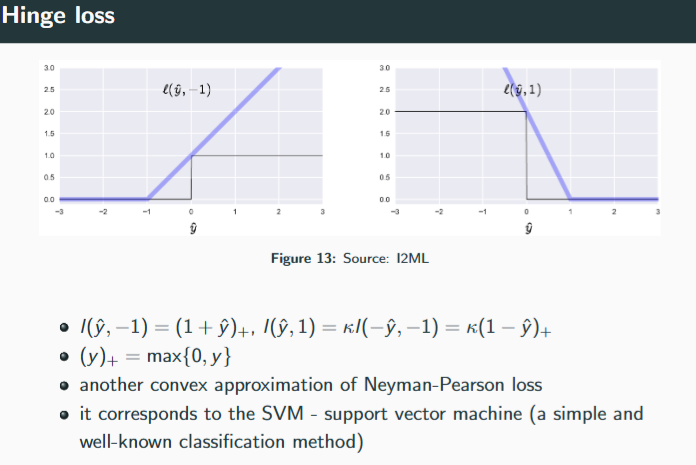

In [4]:
class LossFunction(ABC):
    """
    Abstract base class for loss functions.
    """

    @abstractmethod
    def __call__(self, y_true, y_pred):
        """
        Compute the loss between true and predicted values.
        """
        pass


class HingeLoss(LossFunction):
    """
    Hinge loss function.
    """

    def __call__(self, y_true, y_pred):
        """
        Compute the Hinge asymmetric loss.
        """
        return jnp.maximum(0, 1 - y_pred * y_true)


class HingeAsymmLoss(LossFunction):
    """
    Asymmetric hinge loss function.
    """

    def __init__(self, kappa=1.0):
        """
        Initialize the asymmetric loss with a kappa value.
        The value is transformed to jax array due to better compatibility.
        """
        self.kappa = jnp.array(kappa)

    def __call__(self, y_true, y_pred):
        """
        Compute the Hinge asymmetric loss.
        """
        loss = jnp.where(
            y_true == 1,
            self.kappa * jnp.maximum(0, 1 - y_pred),  # Weighted hinge loss for positives
            jnp.maximum(0, 1 + y_pred),  # Standard hinge loss for negatives
        )
        return loss

Next, we define a linear model that uses a custom loss function together with a regularizer.


In [5]:
class LinearModel():
    """
    Create a JIT-compiled gradient computation function.
    """
    def __call__(self, weights, X, y, loss, regularizer=None):
        # calculation of predictions
        preds = X @ weights
        # obtaining the loss value
        loss_val = loss(y, preds)
        # calculating the empirical risk
        empirical_risk = jnp.mean(loss_val)
        if regularizer is None:
          return empirical_risk
        else:
          return empirical_risk + regularizer(weights)


Below, we define a method for gradient descent.  
It first computes the gradients and compiles the required functions, and then iterates over the dataset to perform the updates.


In [6]:
# Gradient Descent with JAX
def gradient_descent(X, y, loss_func: LossFunction, model, regularizer = None, learning_rate=0.01, n_iterations=1000):
    losses = []
    weights = jnp.ones(X.shape[1])

    # get loss value and gradients of the loss
    def loss_with_grads(weights):
        loss_value = model(weights, X, y, loss_func, regularizer)
        grads = grad(model)(weights, X, y, loss_func, regularizer)
        return loss_value, grads
    # JIT compilation for the gradients
    loss_with_grads = jit(loss_with_grads)

    for i in range(n_iterations):
        # compute loss and gradients
        loss, grads = loss_with_grads(weights)
        # update weights
        weights = weights - learning_rate * grads
        losses.append(loss)
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss:.4f}")

    return weights, losses

Next, we create instances of the loss functions and run gradient descent.  
We begin by creating a `HingeAsymmLoss` object with `kappa = 1`, which makes the loss symmetric.

In [7]:
loss_asym_hinge = HingeAsymmLoss(kappa=1)
full_model_obj = LinearModel()
weights, losses = gradient_descent(X_train, y_train, loss_asym_hinge, model = full_model_obj, learning_rate=0.01, n_iterations=1000)

Iteration 0, Loss: 1.4341
Iteration 100, Loss: 1.2659
Iteration 200, Loss: 1.1157
Iteration 300, Loss: 0.9769
Iteration 400, Loss: 0.8579
Iteration 500, Loss: 0.7582
Iteration 600, Loss: 0.6790
Iteration 700, Loss: 0.6139
Iteration 800, Loss: 0.5688
Iteration 900, Loss: 0.5392


Below, we evaluate the model. To threshold the predictions to the set $\{-1, 1\}$, we use the sign function.  
Examine the confusion matrix of the model. Are the predictions accurate enough?


Train Accuracy: 0.7769
Test Accuracy: 0.7922
train:
[[131  82]
 [ 55 346]]
test:
[[35 20]
 [12 87]]


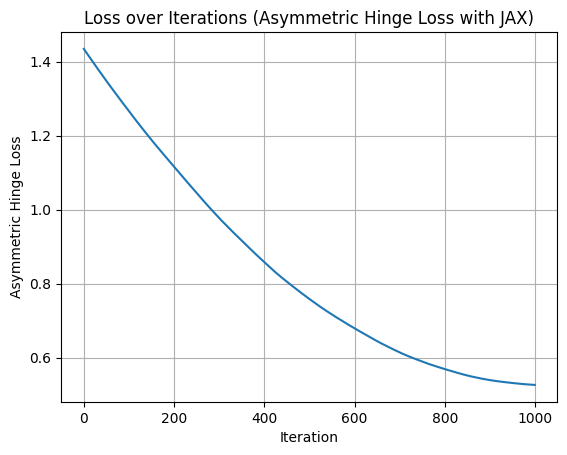

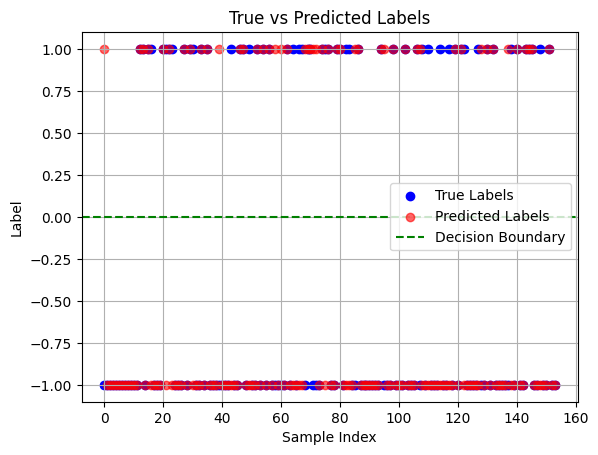

In [8]:
# Evaluate the model
y_pred_train = jnp.dot(X_train, weights)
y_pred_test = jnp.dot(X_test, weights)
y_pred_train_class = jnp.sign(y_pred_train)  # Classify based on sign
y_pred_test_class = jnp.sign(y_pred_test)  # Classify based on sign

print(f"Train Accuracy: {jnp.mean(y_pred_train_class == y_train):.4f}")
print(f"Test Accuracy: {jnp.mean(y_pred_test_class == y_test):.4f}")

# Confusion Matrix
print("train:")
print(confusion_matrix(y_train, y_pred_train_class, labels=[1, -1]))
print("test:")
print(confusion_matrix(y_test, y_pred_test_class, labels=[1, -1]))

# Plot the loss curve
plt.plot(losses)
plt.title("Loss over Iterations (Asymmetric Hinge Loss with JAX)")
plt.xlabel("Iteration")
plt.ylabel("Asymmetric Hinge Loss")
plt.grid()
plt.show()

# Plot predictions vs true labels
plt.scatter(range(len(y_test)), y_test, color="blue", label="True Labels")
plt.scatter(range(len(y_pred_test_class)), y_pred_test_class, color="red", alpha=0.6, label="Predicted Labels")
plt.axhline(0, color="green", linestyle="--", label="Decision Boundary")
plt.title("True vs Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.legend()
plt.grid()
plt.show()

Now, we want to adjust the model so that it is more likely to label individuals as having diabetes, even at the risk of increasing false positives. In other words, it is more harmful to label a person *with* diabetes as healthy than to mislabel a healthy person as having diabetes.

Which value of `kappa` should we choose in the asymmetric hinge loss to reflect this preference?  
Think about how increasing or decreasing `kappa` affects the penalty on negative versus positive misclassifications, and try selecting a value that increases the number of predicted positive cases without significantly reducing overall accuracy.

Additionally, introduce a metric that measures the mode's ability to correctly identify individuals with diabetes—for example.


In [17]:
print("train matrix kappa = 1:")
print(confusion_matrix(y_train, y_pred_train_class, labels=[1, -1]))
print("test matrix kappa = 1:")
print(confusion_matrix(y_test, y_pred_test_class, labels=[1, -1]))

# add your kappa value
kappa_val = 0.5
loss_asym_hinge = HingeAsymmLoss(kappa = kappa_val)
weights_asym, losses = gradient_descent(X_train, y_train, loss_asym_hinge, model = full_model_obj, learning_rate=0.01, n_iterations=1000)


y_pred_train_asym = jnp.dot(X_train, weights_asym)
y_pred_test_asym = jnp.dot(X_test, weights_asym)
y_pred_train_class_asym = jnp.sign(y_pred_train_asym)  # Classify based on sign
y_pred_test_class_asym = jnp.sign(y_pred_test_asym)  # Classify based on sign

print(f"Train Accuracy: {jnp.mean(y_pred_train_class_asym == y_train):.4f}")
print(f"Test Accuracy: {jnp.mean(y_pred_test_class_asym == y_test):.4f}")

# Confusion Matrix
print(f"New train matrix for kappa {kappa_val}:")
print(confusion_matrix(y_train, y_pred_train_class_asym, labels=[1, -1]))
print("New test matrix for kappa {kappa_val}:")
print(confusion_matrix(y_test, y_pred_test_class_asym, labels=[1, -1]))

train matrix kappa = 1:
[[131  82]
 [ 55 346]]
test matrix kappa = 1:
[[35 20]
 [12 87]]
Iteration 0, Loss: 1.3146
Iteration 100, Loss: 1.1496
Iteration 200, Loss: 1.0037
Iteration 300, Loss: 0.8698
Iteration 400, Loss: 0.7502
Iteration 500, Loss: 0.6468
Iteration 600, Loss: 0.5587
Iteration 700, Loss: 0.4826
Iteration 800, Loss: 0.4227
Iteration 900, Loss: 0.3796
Train Accuracy: 0.7752
Test Accuracy: 0.7922
New train matrix for kappa 0.5:
[[107 106]
 [ 32 369]]
New test matrix for kappa {kappa_val}:
[[30 25]
 [ 7 92]]


Below, we provide implementations of several regularizers.  
In this exercise, we will use the `L2RegularizerNoBias`.

In [18]:
class Regularizer(ABC):
    """
    Abstract base class for regularizers.
    """

    @abstractmethod
    def __call__(self, weights):
        """
        Compute the regularization term based on the model weights.
        """
        pass


class L2Regularizer(Regularizer):
    """
    L2 regularization (Ridge regularization).
    """

    def __init__(self, lambda_=0.01):
        """
        Initialize the L2 regularizer with a regularization strength (lambda).
        """
        self.lambda_ = jnp.array(lambda_)

    def __call__(self, weights):
        """
        Compute the L2 regularization term.
        """
        return self.lambda_ * jnp.sum(jnp.square(weights))


class L2RegularizerNoBias(L2Regularizer):
    """
    L2 regularization excluding the bias term (last weight in the weights array).
    """

    def __call__(self, weights):
        """
        Compute the L2 regularization term, excluding the bias.
        """
        # Exclude the last weight (bias term) from L2 regularization
        return self.lambda_ * jnp.sum(jnp.square(weights[:-1]))

Below, we define the `L2Regularizer`, which includes a `lambda_` parameter that controls the strength of the regularization.  
If you increase the value of `lambda_`, consider decreasing the learning rate, as the model becomes more sensitive under stronger regularization penalties.


In [24]:
# Example Usage with L2 Regularization
loss_asym_hinge = HingeAsymmLoss(kappa=1)
l2_regularizer = L2Regularizer(lambda_=0.01)  # L2 regularization with lambda = 0.01

# Create model object
full_model_obj = LinearModel()

# Perform gradient descent with L2 regularization
weights_reg, losses = gradient_descent(
    X_train,
    y_train,
    loss_func=loss_asym_hinge,
    model=full_model_obj,
    regularizer=l2_regularizer,
    learning_rate=0.01,
    n_iterations=1000,
)

y_pred_train_reg = jnp.dot(X_train, weights_reg)
y_pred_test_reg = jnp.dot(X_test, weights_reg)
y_pred_train_class_reg = jnp.sign(y_pred_train_reg)  # Classify based on sign
y_pred_test_class_reg = jnp.sign(y_pred_test_reg)  # Classify based on sign

print(f"Train Accuracy: {jnp.mean(y_pred_train_class_reg == y_train):.4f}")
print(f"Test Accuracy: {jnp.mean(y_pred_test_class_reg == y_test):.4f}")

# Confusion Matrix
print("train matrix original:")
print(confusion_matrix(y_train, y_pred_train_class, labels=[1, -1]))
print("train matrix regularized:")
print(confusion_matrix(y_train, y_pred_train_class_reg, labels=[1, -1]))

print("test matrix original:")
print(confusion_matrix(y_test, y_pred_test_class, labels=[1, -1]))
print("test matrix regularized:")
print(confusion_matrix(y_test, y_pred_test_class_reg, labels=[1, -1]))

print(f"original coefficients: {weights}")
print(f"regularized coefficients {weights_reg}")

Iteration 0, Loss: 1.5241
Iteration 100, Loss: 1.3180
Iteration 200, Loss: 1.1374
Iteration 300, Loss: 0.9767
Iteration 400, Loss: 0.8422
Iteration 500, Loss: 0.7361
Iteration 600, Loss: 0.6534
Iteration 700, Loss: 0.5950
Iteration 800, Loss: 0.5584
Iteration 900, Loss: 0.5439
Train Accuracy: 0.7720
Test Accuracy: 0.7857
train matrix original:
[[131  82]
 [ 55 346]]
train matrix regularized:
[[128  85]
 [ 55 346]]
test matrix original:
[[35 20]
 [12 87]]
test matrix regularized:
[[33 22]
 [11 88]]
original coefficients: [ 0.3241357   0.9230776  -0.16720466 -0.11517289  0.07163453  0.50538653
  0.3367877   0.13583702 -0.5863367 ]
regularized coefficients [ 0.2785294   0.82662004 -0.15996024 -0.10918139  0.04629812  0.45902455
  0.27085677  0.11054908 -0.54937625]


Below, complete the implementation of the sigmoid (logistic) loss function.

In [25]:
class LogisticLoss(LossFunction):
    """
    Logistic loss function (Binary Cross-Entropy Loss for binary classification).
    """

    def __call__(self, y_true, y_pred):
        """
        Compute the logistic loss for true and predicted values.
        Args:
            y_true: Actual target values {-1, 1}.
            y_pred: Predicted values (raw scores, not probabilities).
        Returns:
            Mean logistic loss over all samples.
        """
        # Converts {-1, 1} labels to {0, 1} for compatibility with sigmoid
        y_true_binary = (y_true + 1) / 2.0
        loss = jnp.where(
            y_true_binary == 1,
            jnp.log(1 + jnp.exp(-y_pred)),  # Weighted logistic loss for positives
            jnp.log(1 + jnp.exp(y_pred)),  # Standard logistic loss for negatives
        )
        return loss

The code below puts everything together and evaluates the performance of the logistic loss.


In [26]:
# Example Usage with L2 Regularization
logistic_loss = LogisticLoss()
l2_regularizer = L2Regularizer(lambda_=0.01)  # L2 regularization with lambda = 0.1

# Create model object
full_model_obj = LinearModel()

# Perform gradient descent with L2 regularization
weights_log, losses = gradient_descent(
    X_train,
    y_train,
    loss_func=logistic_loss,
    model=full_model_obj,
    regularizer=l2_regularizer,
    learning_rate=0.01,
    n_iterations=1000,
)

y_pred_train_log = jnp.dot(X_train, weights_log)
y_pred_test_log = jnp.dot(X_test, weights_log)
y_pred_train_class_log = jnp.sign(y_pred_train_log)  # Classify based on sign
y_pred_test_class_log = jnp.sign(y_pred_test_log)  # Classify based on sign

print(f"Train Accuracy: {jnp.mean(y_pred_train_class_log == y_train):.4f}")
print(f"Test Accuracy: {jnp.mean(y_pred_test_class_log == y_test):.4f}")

# Confusion Matrix
print("train matrix original:")
print(confusion_matrix(y_train, y_pred_train_class, labels=[1, -1]))
print("train matrix log loss:")
print(confusion_matrix(y_train, y_pred_train_class_log, labels=[1, -1]))

print("test matrix original:")
print(confusion_matrix(y_test, y_pred_test_class, labels=[1, -1]))
print("test matrix log loss:")
print(confusion_matrix(y_test, y_pred_test_class_log, labels=[1, -1]))

print(f"original coefficients: {weights}")
print(f"log loss coefficients {weights_log}")

Iteration 0, Loss: 1.2617
Iteration 100, Loss: 1.1042
Iteration 200, Loss: 0.9665
Iteration 300, Loss: 0.8493
Iteration 400, Loss: 0.7525
Iteration 500, Loss: 0.6757
Iteration 600, Loss: 0.6173
Iteration 700, Loss: 0.5751
Iteration 800, Loss: 0.5460
Iteration 900, Loss: 0.5268
Train Accuracy: 0.7508
Test Accuracy: 0.7922
train matrix original:
[[131  82]
 [ 55 346]]
train matrix log loss:
[[143  70]
 [ 83 318]]
test matrix original:
[[35 20]
 [12 87]]
test matrix log loss:
[[37 18]
 [14 85]]
original coefficients: [ 0.3241357   0.9230776  -0.16720466 -0.11517289  0.07163453  0.50538653
  0.3367877   0.13583702 -0.5863367 ]
log loss coefficients [ 0.40462667  0.8820524  -0.08472282  0.02611594  0.13938774  0.4928426
  0.37392458  0.2735316  -0.45389518]
